# Simulation

This is all the code for the simulation of the market, including the traders, the asset and the market mechanism.

In [109]:
import numpy as np #import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
from collections import namedtuple
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow import keras

We start by initialising the trading asset, as well as 100 previous random prices so that traders have some material to make their initial trading decisions. These random prices will be kept constant throughout simulations so they don't affect the decisions of the traders between runs. The price at t=0 will be 100 so price movements during the simulation are normalised to an index.

     trading_price  volume  spread  true_price   10_MA  50_MA
-99          96.99       0       0       90.70     NaN    NaN
-98          97.27       0       0       90.79     NaN    NaN
-97          95.30       0       0       90.88     NaN    NaN
-96          95.18       0       0       90.97     NaN    NaN
-95          94.01       0       0       91.06     NaN    NaN
-94          93.70       0       0       91.15     NaN    NaN
-93          92.33       0       0       91.24     NaN    NaN
-92          91.88       0       0       91.32     NaN    NaN
-91          92.85       0       0       91.41     NaN    NaN
-90          92.85       0       0       91.50   94.24    NaN
-89          92.59       0       0       91.59   93.80    NaN
-88          91.90       0       0       91.68   93.26    NaN
-87          92.06       0       0       91.77   92.94    NaN
-86          92.73       0       0       91.86   92.69    NaN
-85          91.83       0       0       91.95   92.47    NaN
-84     

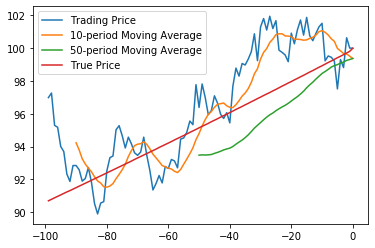

In [235]:
t = 100
period = []
start = -t+1

for i in range(t):
    period.append(start)
    start += 1
    
# asset_prices_rev = []
# price = 100

# for i in range(t):
    # asset_prices_rev.append(price)
    # price = price + np.random.normal(loc=-0.09, scale=1.0, size=None)
    
asset_prices_rev_final = [100, 100.01270443267846, 100.64019372161697, 98.81839318571531, 99.30899479777956, 97.51859080046586, 99.22427385535754, 99.44545557876086, 99.52622326159883, 99.23209122576705, 101.52132601414174, 101.30141646048006, 100.89710059388699, 100.46473999622577, 100.75961538456453, 101.88499554537094, 100.80411278857896, 101.72248034025961, 101.12565566539686, 100.26632483034365, 100.91562712976665, 99.17772539309188, 99.59066814732586, 99.75049301170291, 99.88257405096272, 101.67780729403768, 101.20291667999382, 101.94670634215417, 101.10767031065018, 101.81291988910793, 101.30365747376271, 99.2424041923615, 100.8833495441585, 99.78836505154021, 99.33535482264746, 98.97871646915819, 99.06522794959744, 98.30142009719744, 98.79170348115102, 97.6910991393464, 95.44595047877094, 96.06814982285735, 95.72056059028928, 95.98006873492281, 96.66174879041085, 97.10418900617363, 96.20190098646628, 95.95299800697686, 96.99590538116517, 97.81622741995606, 96.3887487724033, 97.77586186321399, 95.34063768966071, 95.55822196174113, 94.86914074199406, 94.52574130209447, 94.46441233699015, 92.7093912019743, 93.12968534010358, 93.2223145464527, 92.66989504822202, 92.78906639898042, 91.794571679981, 92.23728712947086, 91.7531808557108, 91.36069829889261, 92.5351177867759, 93.46525633285206, 94.57936577428167, 93.6743842774735, 93.47493406493045, 93.6252878884862, 94.17103159031704, 94.57988577655658, 93.92021148266691, 94.66830817347167, 95.2828076714649, 95.03199804355003, 93.43284668672827, 93.33299029582979, 92.51972813503856, 90.65244342293956, 90.55553325883402, 89.89860870807794, 90.5321278206722, 91.82820852517096, 92.73328391342815, 92.05545521924738, 91.89793090418809, 92.59268573869126, 92.84506087167615, 92.8490494107132, 91.88331933594272, 92.3255816844502, 93.70032141468926, 94.00839921394368, 95.17675414492784, 95.29954443407748, 97.27212940879878, 96.98808834932551]

asset_prices_rev_final.reverse()

asset_prices_rev_final_rounded = []

for i in asset_prices_rev_final:
    j = round(i, 2)
    asset_prices_rev_final_rounded.append(j)
    
asset_prices = asset_prices_rev_final_rounded
        
true_prices = []
tp = 100/((1.05)**2)
    
for i in range(t-1):
    true_prices.append(round(tp, 2)) #Assume true price unchanged in this period - remained 100
    tp = tp*((1.05)**(1/50))
    
true_prices.append(100)
    
def evolve(df): # Define the function that determines the evolution of the true asset price over time
    last_price = df.iloc[-1]["true_price"]
    ret = (1.05)**(1/50)
    base_price = last_price*ret #The true price evolves to give a 5% return every 50 periods
    shock_p = np.random.randint(100, size=1) #There are some shocks to the true price, some large and some small
    shock = 0
    if shock_p < 5:
        shock = np.random.normal(loc=0, scale=1.5, size=None)
    elif shock_p > 5 and shock_p < 30:
        shock = np.random.normal(loc=0, scale=0.25, size=None)
    next_price = round((base_price + shock), 2)
    return next_price
    
def moving_average_list(price_list, window): #Define a function to calculate simple moving averages
    window_size = window
    price_series = pd.Series(price_list)
    windows = price_series.rolling(window_size)
    ma = round(windows.mean(), 2)
    ma_list = ma.tolist()
    return ma_list
    
mas = moving_average_list(asset_prices, 10) #Generate shorter moving average
mal = moving_average_list(asset_prices, 50) #Generate longer moving average

vol_list = []
spread_list = []
for i in range(100):
    vol_list.append(0)
    spread_list.append(0)

#assetdf = pd.DataFrame(data={"trading_price": asset_prices, "true_price": true_prices, "10_MA": mas, "50_MA": mal}, index=period)
assetdf = pd.DataFrame(data={"trading_price": asset_prices, "volume": vol_list, "spread": spread_list, "true_price": true_prices, "10_MA": mas, "50_MA": mal}, index=period)

plt.plot(assetdf.index, assetdf["trading_price"], label="Trading Price")
plt.plot(assetdf.index, assetdf["10_MA"], label="10-period Moving Average")
plt.plot(assetdf.index, assetdf["50_MA"], label="50-period Moving Average")
plt.plot(assetdf.index, assetdf["true_price"], label="True Price")
plt.legend()
print(assetdf)

def clean_df():
    assetdf = pd.DataFrame(data={"trading_price": asset_prices, "volume": vol_list, "spread": spread_list, "true_price": true_prices, "10_MA": mas, "50_MA": mal}, index=period)
    return assetdf

In the next cell we define the different flavours of traders and the syntax of how they receive information and place orders accordingly. Flavours include chartists ("chart"), fundamentalists/arbitrageurs ("arb"), value traders ("val") and noise traders ("noise"). The LSTM traders will be included later once a working market has been established.

Chartists represent the technical analysts of the world. They have 2 indicators (based solely on the previous prices of the asset) from which they base their expectations of market development. The indicators are moving averages which assess the trend of price-action (when the shorter period MA crosses the larger one that indicates a shift in trend). While the reliability of these indicators are empirically ambiguous in academic circles, they are widely used across technical analysts in the retail trading community.

Fundamentalists exist to constantly provide pressure towards the "true" price of the asset. They will act as arbitrageurs to push the price towards the true price of the asset. The further away price deviates from the "true" price, the higher the order size grows as they believe the asset is truly under/overvalued. For the purposes of simplicity, a true price will be given exogenously, and will evolve linearly with some random shocks. Value traders are those that believe "time in the market beats timing the market" and will buy and hold the asset over time. They expect to make their returns over the long term based on the true price of the asset growing (and the trading price reflecting this).

Noise traders have no specific strategy and simply buy and sell at random to provide volume in the market. The real world equivalent for this could be considered to be uninformed retail traders.

In [23]:
def w(p): # Define the probability weighting function (prospect theory) for the utility of the traders
    g = 0.5 # G for gamma (0.5 taken from empirical studies)
    return (p**g)/((p**g+(1-p)**g)**(1/g))

#def v(x): #Define the value function (prospect theory) for the utility of the traders
#    a = 0.44 # a for alpha (all parameter values have been taken from empirical studies)
#    b = 0.49 # b for beta
#    l = 1.06 # l for lambda
#    if x >= 0:
#        v = x**a
#    elif x < 0:
#        v = -l(-x)**b
#    return v

def sigmoid(x): #Used to transform inputs in range (-inf,inf) to (0,1) for probabilities
    return 1/(1 + np.exp(-x))

class Trader:
    
    def v(self, x): #Define the value function (prospect theory) for the utility of the traders
        self.x = x
#        self.val = 0
        self.a = 0.44 # a for alpha (all parameter values have been taken from empirical studies)
        self.b = 0.49 # b for beta
        self.l = 1.06 # l for lambda
        if self.x >= 0:
            self.val = self.x**self.a
        elif self.x < 0:
            self.val = -self.l*(-self.x)**self.b
        return self.val
                        
    def __init__(self, flavour, ID):
        self.flavour = flavour     
        self.activ = np.random.uniform() #Activation frequency of each trader
        self.bal = 5_000
        self.tp_error = np.random.normal(loc=0, scale=1.5, size=None)
        self.stock = 50
        self.scale = np.random.uniform(low=1, high=2) #The scale by which order sizes are increased above utility
        self.acc = self.stock*100 + self.bal # Account size equals value of stock + value of cash balance            
        self.id = "id" + str(ID)
        self.faith = np.random.uniform() #The proclivity of the agent to stick to its current trading strategy
        self.back = round(10*self.faith) #How far back chartists go to determine returns
        self.val = 0
        self.util = 0
        self.random = np.random.normal(loc=3, scale=1, size=None)
        self.quantity = 0
        
    def placebid(self): #Bid needs to be made in the form bid = (quantity, price, userID, isBuying=True)
        
        if self.flavour == "arb" or self.flavour == "chart":
            self.bidprice = round(assetdf.iloc[-1]["trading_price"] + self.faith, 2)
            self.quantity = round(self.util*self.scale)
            
        elif self.flavour == "val":
            self.bidprice = round(assetdf.iloc[-1]["trading_price"] + self.faith, 2)
            self.quantity = abs(round(np.random.normal(loc=3, scale=1, size=None)))
            
        elif self.flavour == "noise":
            self.bidprice = round(assetdf.iloc[-1]["trading_price"] + self.faith, 2)
            self.quantity = abs(round(np.random.normal(loc=3, scale=1, size=None)))
        
        if self.quantity*self.bidprice > self.bal:
            self.quantity = math.floor(self.bal/self.bidprice)
#        if self.quantity < 1:
#            self.quantity = 1
        self.bid = (self.quantity, self.bidprice, self.id, True)
        return self.bid
        
    def placeask(self): #Same form as bids but with isBuying=False
            
        if self.flavour == "arb" or self.flavour == "chart":
            self.askprice = round(assetdf.iloc[-1]["trading_price"] - self.faith, 2)
            self.quantity = round(self.util*self.scale)
            
        elif self.flavour == "val":
            self.askprice = round(assetdf.iloc[-1]["trading_price"] - self.faith, 2)
            self.quantity = round(self.stock/2)
            
        elif self.flavour == "noise":
            self.askprice = round(assetdf.iloc[-1]["trading_price"] - self.faith, 2)
            self.quantity = round(np.random.normal(loc=3, scale=1, size=None))

#        if self.quantity < 1:
#            self.quantity = 1            
        if self.quantity > self.stock:
            self.quantity = self.stock
        self.ask = (self.quantity, self.askprice, self.id, False)
        return self.ask
                        
    def trade(self):
        if self.flavour == "chart":
            if assetdf.iloc[-1]["10_MA"] > assetdf.iloc[-1]["50_MA"]:
                self.xgood = assetdf["trading_price"].max() - assetdf.iloc[-1]["trading_price"]
                self.xbad = assetdf.iloc[-1]["50_MA"] - assetdf.iloc[-1]["trading_price"]
                self.pgood = sigmoid(100*((assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-(1+self.back)]["trading_price"])/assetdf.iloc[-(1+self.back)]["trading_price"]))
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
                self.util = self.v(self.lot)
                if self.util > 0.5:
                    return self.placebid()
            elif assetdf.iloc[-1]["10_MA"] < assetdf.iloc[-1]["50_MA"]:
                self.xgood = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].min()
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["50_MA"]
                self.pgood = sigmoid(-100*((assetdf.iloc[-1]["trading_price"]-assetdf.iloc[-(1+self.back)]["trading_price"])/assetdf.iloc[-(1+self.back)]["trading_price"]))
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
                self.util = self.v(self.lot)
                if self.util > 0.5:
                    return self.placeask()
            
        elif self.flavour == "arb":
            if assetdf.iloc[-1]["trading_price"] < assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.xgood = assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf.iloc[-1]["trading_price"]
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].min()
                self.pgood = (assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf.iloc[-1]["trading_price"])/(assetdf.iloc[-1]["true_price"] + self.tp_error - assetdf["trading_price"].min())
                self.pbad = 1 - self.pgood
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.pbad)
#                print(self.lot)
                self.util = self.v(self.lot)
#                print("util = " + str(self.util))
                if self.util > 0.5:
                    return self.placebid()
            elif assetdf.iloc[-1]["trading_price"] > assetdf.iloc[-1]["true_price"] + self.tp_error:
                self.xgood = assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["true_price"] + self.tp_error
                self.xbad = assetdf.iloc[-1]["trading_price"] - assetdf["trading_price"].max()
                self.pgood = (assetdf.iloc[-1]["trading_price"] - assetdf.iloc[-1]["true_price"] + self.tp_error)/(assetdf["trading_price"].max() - assetdf.iloc[-1]["true_price"] + self.tp_error)
                self.lot = self.xgood*w(self.pgood) + self.xbad*w(self.xbad)
                self.util = self.v(self.lot)
#                print("util = " + str(self.util))
                if self.util > 0.5:
                    return self.placeask()

        elif self.flavour == "val":
            if self.activ > activ_rate:
                if assetdf.iloc[-1]["trading_price"] >= assetdf["trading_price"].max():
                    return self.placeask()
                else:
                    return self.placebid()
                    
        elif self.flavour == "noise":
            if self.activ > activ_rate:
                if np.random.normal() > 0:
                    return self.placebid()
                else:
                    return self.placeask()

Next we set up the environment for the market. This begins by setting up the method to generate traders at the start of each simulation. We also define the market mechanism, which is inspired by the Caltech "flex-e" mechanism: http://www.its.caltech.edu/~pbs/fm/chunks/ch10.html

In [88]:
TraderNumbers = namedtuple("NumberTraders", "Arb_Traders Chart_Traders Val_Traders Noise_Traders".split())
arbrate = 25
chartrate = 25
valrate = 25
noiserate = 25
n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
TRADERS_INDICES = np.cumsum(n_traders)

def trader_proportions():
    numlist = []
    while len(numlist) < 3:
        x = random.randint(1, 103)
        if x not in numlist:
            numlist.append(x)
    numlist.sort()
    a = numlist[0] - 1
    b = numlist[1] - numlist[0] - 1
    c = numlist[2] - numlist[1] - 1
    d = 103 - numlist[2]
    return a, b, c, d

def choose_trader(idx):
    if idx <= TRADERS_INDICES[0]:
        return Trader("arb", idx)
    elif TRADERS_INDICES[0] < idx <= TRADERS_INDICES[1]:
        return Trader("chart", idx)
    elif TRADERS_INDICES[1] < idx <= TRADERS_INDICES[2]:
        return Trader("val", idx)
    return Trader("noise", idx)
    
def gen_traders():
    traders_set = [choose_trader(i) for i in range(TRADERS_INDICES[-1])]
    id_dict = {participant.id: participant for participant in traders_set}
    return traders_set, id_dict

In [101]:
def run_market(bids_list, asks_list, iddict, traders_set):
    bidsdf = pd.DataFrame(bids, columns=["b_q", "b_p", "b_id", "buy"])
    asksdf = pd.DataFrame(asks, columns=["a_q", "a_p", "a_id", "buy"])
    bidsdf = bidsdf.drop(columns=["buy"])
    asksdf = asksdf.drop(columns=["buy"])
    bidsdf = bidsdf.sort_values(by=["b_p", "b_q", "b_id"], ascending=False)
    asksdf = asksdf.sort_values(by=["a_p", "a_q", "a_id"], ascending=True)
    bidsdf = bidsdf.reset_index(drop=True)
    asksdf = asksdf.reset_index(drop=True)
    bidsdf1 = bidsdf.copy()
    asksdf1 = asksdf.copy()
    
    bal_data = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data.append(row)
    tradersdf1 = pd.DataFrame(data=bal_data, columns=["id", "stock", "bal", "acc", "flavour"])
    
    singlebidlist = []
    for index, row in bidsdf1.iterrows():
        while row["b_q"] > 1:
            singlebidlist.append({"b_q": 1, "b_p": row["b_p"], "b_id": row["b_id"]})
            row["b_q"] -= 1
        bidsdf1.at[index, "b_q"] = 1
    for i in singlebidlist:
        bidsdf1 = bidsdf1.append(i, ignore_index=True)
    bidsdf1 = bidsdf1.sort_values(by=["b_p", "b_q"], ascending=False)
    
    singleasklist = []
    for index, row in asksdf1.iterrows():
        while row["a_q"] > 1:
            singleasklist.append({"a_q": 1, "a_p": row["a_p"], "a_id": row["a_id"]})
            row["a_q"] -= 1
        asksdf1.at[index, "a_q"] = 1
    for i in singleasklist:
        asksdf1 = asksdf1.append(i, ignore_index=True)
    asksdf1 = asksdf1.sort_values(by=["a_p", "a_q"], ascending=True)
    
    clearing_price = 0
    clearing_index = 0
    bidscopy = bidsdf1.copy()
    askscopy = asksdf1.copy()
    bidscopy = bidscopy.reset_index(drop=True)
    askscopy = askscopy.reset_index(drop=True)
    totaldf = pd.concat([bidscopy, askscopy], axis=1, sort=False)
    
    for index, row in totaldf.iterrows():
        if math.isnan(row["b_p"]):
            clearing_price = totaldf.iloc[index-1]["a_p"]
            clearing_index = index - 1
            break
        elif math.isnan(row["a_p"]):
            clearing_price = totaldf.iloc[index-1]["b_p"]
            clearing_index = index - 1
            break
        elif row["b_p"] < row["a_p"]:
            lastask = totaldf.iloc[index-1]["a_p"]
            nextbid = totaldf.iloc[index]["b_p"]
            if lastask > nextbid:
                clearing_price = lastask
                clearing_index = index - 1
                break
            elif lastask <= nextbid:
                clearing_price = nextbid
                clearing_index = index - 1
                break
        elif index == len(totaldf)-1:
            clearing_price = (totaldf.iloc[index]["b_p"]+totaldf.iloc[index]["a_p"])/2
            clearing_index = index
                
#    print(clearing_price)
#    print(clearing_index)
    
    for index, row in totaldf.iterrows():
        iddict[str(row["b_id"])].stock += 1
        iddict[str(row["a_id"])].bal += clearing_price
        iddict[str(row["b_id"])].bal -= clearing_price
        iddict[str(row["a_id"])].stock -= 1
#        print(str(index) + "trade done")
        if index == clearing_index:
            break
            
    for participant in traders_set:
        participant.acc = participant.stock*clearing_price + participant.bal
        
    spread = round(totaldf.iloc[0]["b_p"] - totaldf.iloc[0]["a_p"], 2)
    
    bal_data_new = []
    for participant in traders_set:
        row = [participant.id, participant.stock, participant.bal, participant.acc, participant.flavour]
        bal_data_new.append(row)
    tradersdf2 = pd.DataFrame(data=bal_data_new, columns=["id", "stock", "bal", "acc", "flavour"])
    
    statistics = {"trading_price": clearing_price, "volume": clearing_index, "spread": spread}    
    
    return statistics, tradersdf1, tradersdf2

In [293]:
def staticma(short, window): #More computationally efficient functions for generating moving averages each period
    newma = 0
    if short:
        newma = assetdf.iloc[-1]["10_MA"] + (1/(window))*(stats["trading_price"]-assetdf.iloc[-(window+1)]["trading_price"])
    else:
        newma = assetdf.iloc[-1]["50_MA"] + (1/(window))*(stats["trading_price"]-assetdf.iloc[-(window+1)]["trading_price"])
    return newma

def mutate(statedf): #Define the function that allows traders to switch types during simulations
    topacc = 0
    topflavour = "None"
    for i, j in enumerate(statedf["acc"]): #Get top performer
        if j > topacc:
            if statedf.iloc[i]["flavour"] == "lstm":
                continue
            else:
                topacc = j
                topflavour = statedf.iloc[i]["flavour"]
    for trader in traders_set: #Change to top performer if desired
        if trader.flavour != "lstm":
            if trader.faith < faith_rate:
                trader.flavour = topflavour

Once we have everything initialised, we begin to run the simulations for generation 0 (no LSTM traders). We will be running 100 simulations of 500 time periods. Data is stored in csv files (which can also be found in the repository).

In [103]:
"""GENERATION 0"""
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen0_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen0_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = "gen0sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen0_sims/data/{csv_name}.csv')



  0%|          | 0/100 [00:00<?, ?it/s]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


  1%|          | 1/100 [03:11<5:15:53, 191.45s/it]

  2%|▏         | 2/100 [04:19<4:12:02, 154.31s/it]

  3%|▎         | 3/100 [08:02<4:43:00, 175.06s/it]

  4%|▍         | 4/100 [11:16<4:49:06, 180.69s/it]

  5%|▌         | 5/100 [14:54<5:04:02, 192.03s/it]

  6%|▌         | 6/100 [18:23<5:08:24, 196.85s/it]

  7%|▋         | 7/100 [21:15<4:53:46, 189.53s/it]

  8%|▊         | 8/100 [22:58<4:10:36, 163.44s/it]

  9%|▉         | 9/100 [24:19<3:30:25, 138.74s/it]

 10%|█         | 10/100 [28:27<4:17:13, 171.49s/it]

 11%|█         | 11/100 [34:04<5:28:17, 221.32s/it]

 12%|█▏        | 12/100 [37:39<5:21:48, 219.42s/it]

 13%|█▎        | 13/100 [40:50<5:05:35, 210.76s/it]

 14%|█▍        | 14/100 [44:28<5:05:16, 212.98s/it]

Now that we have one generation of data, we can train our first generation LSTM trader. The code for this can be found in this repository under "lstm1". Now we can add it as a trader and then generate the data for generation 1. 

In [314]:
lstm1 = keras.models.load_model("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm1")

In [326]:
def transform_data(df, gen): #Takes the assetdf and outputs an array the model can predict on
    v = df.iloc[-21:-1][["trading_price", "true_price"]].to_numpy()
    v = np.log(v)
    if gen == 1:
        xmean = np.array([4.73053996, 4.78413082])
        xstd = np.array([np.sqrt(0.03715021),np.sqrt(0.01395239)])
    if gen == 2:
        xmean = np.array([4.7065291, 4.78767914])
        xstd = np.array([np.sqrt(0.05321885),np.sqrt(0.01509073)])
    if gen == 3:
        xmean = np.array([4.69423324, 4.7940176])
        xstd = np.array([np.sqrt(0.06078981), np.sqrt(0.01565027)])
    if gen == 4:
        xmean = np.array([4.67667505, 4.79155419])
        xstd = np.array([np.sqrt(0.07729432), np.sqrt(0.0161154)])
    if gen == 5:
        xmean = np.array(4.59605833, 4.79008357)
        xstd = np.array([0.14824653 0.01544488])
    v = np.add(v, -xmean)
    v = np.true_divide(v, xstd)
    v = np.reshape(v, (1, v.shape[0], v.shape[1]))
    return v

def inverse_transform(pred, gen):
    if gen == 1:
        p = pred*np.sqrt(0.04016007) + 4.73700706
    if gen == 2:
        p = pred*np.sqrt(0.05840521) + 4.71154396
    if gen == 3:
        p = pred*np.sqrt(0.06571498) + 4.69863827
    if gen == 4:
        p = pred*np.sqrt(0.08509756) + 4.67906749
    if gen == 5:
        p = pred*np.sqrt(0.16311941) + 4.59506378
    p = math.exp(p)
    return p

class lstm_Trader: #Define the class for LSTM traders, and their interactability with the market
    def __init__(self, ID, model, gen):
        self.id = "id" + str(ID)
        self.bal = 5_000
        self.stock = 50
        self.acc = self.stock*assetdf.iloc[-1]["trading_price"] + self.bal
        self.quantity = 0
        self.model = model
        self.scale = 5
        self.flavour = "lstm"
        self.gen = gen
        
    def placebid(self, price):
        self.diff = price - assetdf.iloc[-1]["trading_price"]
        self.bidprice = round(price, 2)
        self.quantity = round(self.scale*self.diff)
        if self.quantity*self.bidprice > self.bal:
            self.quantity = math.floor(self.bal/self.bidprice)
        self.bid = (self.quantity, self.bidprice, self.id, True)
        return self.bid
        
    def placeask(self, price):
        self.diff = assetdf.iloc[-1]["trading_price"] - price
        self.askprice = round(price, 2)
        self.quantity = round(self.scale*self.diff)
        if self.quantity > self.stock:
            self.quantity = self.stock
        self.ask = (self.quantity, self.askprice, self.id, False)
        return self.ask
    
    def trade(self):
        self.input = transform_data(assetdf, self.gen)
        self.pred = self.model(self.input).numpy()
        self.price = inverse_transform(self.pred, self.gen)
        if self.price > assetdf.iloc[-1]["trading_price"]:
            return self.placebid(self.price)
        elif self.price < assetdf.iloc[-1]["trading_price"]:
            return self.placeask(self.price)

SyntaxError: invalid syntax (<ipython-input-326-eea37fc64f02>, line 18)

In [295]:
"""GENERATION 1"""
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    id100 = lstm_Trader(100, lstm1, 1)
    traders_set.append(id100)
    id_dict["id100"] = id100
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen1_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen1_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = "gen1sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen1_sims/data/{csv_name}.csv')





  0%|          | 0/100 [00:00<?, ?it/s]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until




  1%|          | 1/100 [04:14<6:59:18, 254.12s/it]



  2%|▏         | 2/100 [08:54<7:08:04, 262.09s/it]



  3%|▎         | 3/100 [10:40<5:48:02, 215.28s/it]



  4%|▍         | 4/100 [12:11<4:44:28, 177.79s/it]



  5%|▌         | 5/100 [14:08<4:12:41, 159.60s/it]



  6%|▌         | 6/100 [17:44<4:36:26, 176.45s/it]



  7%|▋         | 7/100 [22:21<5:20:13, 206.60s/it]



  8%|▊         | 8/100 [30:35<7:29:14, 292.99s/it]



  9%|▉         | 9/100 [36:21<7:48:35, 308.96s/it]



 10%|█         | 10/100 [49:09<11:09:57, 446.64s/it]



 11%|█         | 11/100 [51:32<8:47:07, 355.36s/it] 



 12%|█▏        | 12/100 [55:29<7:49:19, 319.99s/it]



 13%|█▎        | 13/100 [1:04:04<9:08:41, 378.40s/it]



 14%|█▍        | 

In [319]:
lstm2 = keras.models.load_model("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm2")

In [308]:
"""GENERATION 2"""
gen = 2
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    id100 = lstm_Trader(100, lstm1, 1)
    id101 = lstm_Trader(101, lstm2, 2)
    traders_set.append(id100)
    traders_set.append(id101)
    id_dict["id100"] = id100
    id_dict["id101"] = id101
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = f"gen{gen}sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/data/{csv_name}.csv')










  0%|          | 0/100 [00:00<?, ?it/s]








  1%|          | 1/100 [03:56<6:30:58, 236.96s/it]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until









  2%|▏         | 2/100 [11:27<8:11:40, 301.02s/it]








  3%|▎         | 3/100 [18:01<8:51:51, 328.98s/it]








  4%|▍         | 4/100 [20:41<7:25:22, 278.36s/it]








  5%|▌         | 5/100 [22:20<5:55:16, 224.39s/it]








  6%|▌         | 6/100 [31:26<8:22:54, 321.01s/it]








  7%|▋         | 7/100 [32:31<6:18:28, 244.18s/it]








  8%|▊         | 8/100 [34:06<5:05:39, 199.34s/it]








  9%|▉         | 9/100 [40:45<6:33:20, 259.35s/it]








 10%|█         | 10/100 [44:23<6:10:04, 246.71s/it]








 11%|█         | 11/100 [47:10<5:30:36, 222.89s/it]








 12%|█▏        | 12/100 [50:08<5:07:22, 209.57s/it]








 13%|█

 90%|█████████ | 90/100 [7:31:57<30:42, 184.22s/it]








 91%|█████████ | 91/100 [7:34:12<25:26, 169.58s/it]








 92%|█████████▏| 92/100 [7:36:09<20:29, 153.70s/it]








 93%|█████████▎| 93/100 [7:39:22<19:18, 165.56s/it]








 94%|█████████▍| 94/100 [7:46:53<25:06, 251.04s/it]








 95%|█████████▌| 95/100 [7:48:40<17:19, 207.95s/it]








 96%|█████████▌| 96/100 [7:51:12<12:43, 190.98s/it]








 97%|█████████▋| 97/100 [7:54:33<09:42, 194.05s/it]








 98%|█████████▊| 98/100 [7:56:06<05:27, 163.73s/it]








 99%|█████████▉| 99/100 [7:58:36<02:39, 159.60s/it]








100%|██████████| 100/100 [8:01:44<00:00, 289.04s/it]


In [322]:
"""GENERATION 3"""
lstm3 = keras.models.load_model("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm3")
gen = 3
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    id100 = lstm_Trader(100, lstm1, 1)
    id101 = lstm_Trader(101, lstm2, 2)
    id102 = lstm_Trader(102, lstm3, 3)
    traders_set.append(id100)
    traders_set.append(id101)
    traders_set.append(id102)
    id_dict["id100"] = id100
    id_dict["id101"] = id101
    id_dict["id102"] = id102
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = f"gen{gen}sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/data/{csv_name}.csv')










  0%|          | 0/100 [00:00<?, ?it/s]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until









  1%|          | 1/100 [02:13<3:40:47, 133.82s/it]








  2%|▏         | 2/100 [04:02<3:26:23, 126.36s/it]








  3%|▎         | 3/100 [07:02<3:50:02, 142.29s/it]








  4%|▍         | 4/100 [11:04<4:35:45, 172.35s/it]








  5%|▌         | 5/100 [12:53<4:02:34, 153.21s/it]








  6%|▌         | 6/100 [14:15<3:26:31, 131.82s/it]








  7%|▋         | 7/100 [17:04<3:41:31, 142.92s/it]








  8%|▊         | 8/100 [19:28<3:39:46, 143.33s/it]








  9%|▉         | 9/100 [22:22<3:51:24, 152.58s/it]








 10%|█         | 10/100 [23:50<3:19:37, 133.08s/it]








 11%|█         | 11/100 [33:51<6:45:58, 273.69s/it]








 12%|█▏        | 12/100 [36:50<5:59:28, 245.10s/it]








 13%|█

 90%|█████████ | 90/100 [4:43:27<33:08, 198.90s/it]








 91%|█████████ | 91/100 [4:45:39<26:51, 179.03s/it]








 92%|█████████▏| 92/100 [4:47:06<20:09, 151.22s/it]








 93%|█████████▎| 93/100 [4:48:31<15:19, 131.41s/it]








 94%|█████████▍| 94/100 [4:51:34<14:42, 147.05s/it]








 95%|█████████▌| 95/100 [4:53:15<11:06, 133.26s/it]








 96%|█████████▌| 96/100 [5:00:06<14:25, 216.36s/it]








 97%|█████████▋| 97/100 [5:01:19<08:40, 173.41s/it]








 98%|█████████▊| 98/100 [5:08:35<08:24, 252.30s/it]








 99%|█████████▉| 99/100 [5:11:24<03:47, 227.22s/it]








100%|██████████| 100/100 [5:14:50<00:00, 188.90s/it]


In [325]:
"""GENERATION 4"""
lstm4 = keras.models.load_model("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm4")
gen = 4
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    id100 = lstm_Trader(100, lstm1, 1)
    id101 = lstm_Trader(101, lstm2, 2)
    id102 = lstm_Trader(102, lstm3, 3)
    id103 = lstm_Trader(103, lstm4, 4)
    traders_set.append(id100)
    traders_set.append(id101)
    traders_set.append(id102)
    traders_set.append(id103)
    id_dict["id100"] = id100
    id_dict["id101"] = id101
    id_dict["id102"] = id102
    id_dict["id103"] = id103
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = f"gen{gen}sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/data/{csv_name}.csv')











  0%|          | 0/100 [00:00<?, ?it/s]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until










  1%|          | 1/100 [04:01<6:38:20, 241.41s/it]









  2%|▏         | 2/100 [08:14<6:40:03, 244.93s/it]









  3%|▎         | 3/100 [13:58<7:24:06, 274.70s/it]









  4%|▍         | 4/100 [18:45<7:25:04, 278.18s/it]









  5%|▌         | 5/100 [21:00<6:12:49, 235.47s/it]









  6%|▌         | 6/100 [24:12<5:48:06, 222.20s/it]









  7%|▋         | 7/100 [27:01<5:20:05, 206.51s/it]









  8%|▊         | 8/100 [31:44<5:51:28, 229.23s/it]









  9%|▉         | 9/100 [34:11<5:10:31, 204.74s/it]









 10%|█         | 10/100 [36:58<4:49:52, 193.25s/it]









 11%|█         | 11/100 [44:04<6:30:13, 263.07s/it]









 12%|█▏        | 12/100 [46:46<5:41:40, 232.96s/it]



 86%|████████▌ | 86/100 [5:26:19<48:08, 206.31s/it]









 87%|████████▋ | 87/100 [5:29:00<41:46, 192.84s/it]









 88%|████████▊ | 88/100 [5:30:55<33:54, 169.50s/it]









 89%|████████▉ | 89/100 [5:33:29<30:13, 164.83s/it]









 90%|█████████ | 90/100 [5:35:18<24:39, 147.93s/it]









 91%|█████████ | 91/100 [5:41:37<32:34, 217.18s/it]









 92%|█████████▏| 92/100 [5:43:34<24:58, 187.35s/it]









 93%|█████████▎| 93/100 [5:48:00<24:36, 210.94s/it]









 94%|█████████▍| 94/100 [5:50:56<20:02, 200.35s/it]









 95%|█████████▌| 95/100 [5:52:30<14:01, 168.35s/it]









 96%|█████████▌| 96/100 [5:53:44<09:20, 140.24s/it]









 97%|█████████▋| 97/100 [5:59:45<10:18, 206.30s/it]









 98%|█████████▊| 98/100 [6:02:17<06:20, 190.06s/it]









 99%|█████████▉| 99/100 [6:04:52<02:59, 179.54s/it]









100%|██████████| 100/100 [6:07:31<00:00, 220.52s/it]


In [ ]:
"""GENERATION 5"""
lstm5 = keras.models.load_model("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm5")
gen = 5
for sim in tqdm(range(1, 101)):
    arbrate, chartrate, valrate, noiserate = trader_proportions()
    n_traders = TraderNumbers(arbrate, chartrate, valrate, noiserate)
    TRADERS_INDICES = np.cumsum(n_traders)
    traders_set, id_dict = gen_traders()
    id100 = lstm_Trader(100, lstm1, 1)
    id101 = lstm_Trader(101, lstm2, 2)
    id102 = lstm_Trader(102, lstm3, 3)
    id103 = lstm_Trader(103, lstm4, 4)
    id104 = lstm_Trader(104, lstm5, 5)
    traders_set.append(id100)
    traders_set.append(id101)
    traders_set.append(id102)
    traders_set.append(id103)
    id_dict["id100"] = id100
    id_dict["id101"] = id101
    id_dict["id102"] = id102
    id_dict["id103"] = id103
    assetdf = clean_df()
    state0name = "state0sim" + str(sim)
    finalstatename = "finalstatesim" + str(sim)

    for t in range(1,501):
        for participant in traders_set:
            if participant.stock == 0 and participant.bal < assetdf.iloc[-1]["trading_price"]:
                traders_set.remove(participant)
        bids = []
        asks = []
        activ_rate = np.random.uniform()
        faith_rate = np.random.uniform()
        for participant in traders_set:
            order = participant.trade()
            if type(order) == tuple and order[3] == True and order[0] > 0:
                bids.append(order)
            if type(order) == tuple and order[3] == False and order[0] > 0:
                asks.append(order)
        if len(bids) == 0 or len(asks) == 0: 
            continue
        stats, state0, state1 = run_market(bids, asks, id_dict, traders_set)
        if t == 1:
            state0.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{state0name}.csv')
        next_price = evolve(assetdf)
        shortma = staticma(True, 10)
        longma = staticma(False, 50)
        stats["true_price"] = next_price
        stats["10_MA"] = round(shortma, 2)
        stats["50_MA"] = round(longma, 2)
        appendlist = []
        for k,v in stats.items():
            appendlist.append(v)
        assetdf.loc[t] = appendlist
        if t%100 == 0:
            mutate(state1)
    state1.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/states/{finalstatename}.csv')
    finaldf = assetdf[99:]
    csv_name = f"gen{gen}sim" + str(sim)
    finaldf.to_csv(f'/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen{gen}_sims/data/{csv_name}.csv')











  0%|          | 0/100 [00:00<?, ?it/s]/Users/karangarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
